In [42]:
%matplotlib inline
import math
import os
import mne
import pandas as pd
from mne.externals.pymatreader import read_mat 
import numpy as np
import matplotlib.pyplot as plt
import itertools
from glob import glob
from scipy import io
import scipy

import pyriemann
from pyriemann.classification import KNearestNeighbor

from sklearn.linear_model import LogisticRegression 
from sklearn.model_selection import cross_val_score 
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score
from sklearn.metrics import mutual_info_score
from scipy.sparse.csgraph import minimum_spanning_tree
from scipy.sparse import csgraph

import matplotlib.cm as cm
import matplotlib.animation as animation

In [2]:
data_path='/Users/charlesgirard/Desktop/Centrale/ei2/Projet/P01'
n_subs = 4
n_sessions = 2
diff = ['MATBeasy', 'MATBmed', 'MATBdiff']

In [3]:
electrodes = pd.read_csv(data_path + '/S1/electrode_positions/get_chanlocs.txt',header=None, names=['ch_names','x','y','z'],delim_whitespace=True)
electrodes.head()
#reagrder noms channels

,ch_names,x,y,z
0,Fp1,105.9276,29.3422,66.8159
1,Fz,66.4484,-2.1494,123.7135
2,F3,59.9094,45.3245,102.7517
3,F7,62.0175,68.6308,59.5730
4,F9,34.2379,78.5712,7.9506


array([1, 2])

(500,)



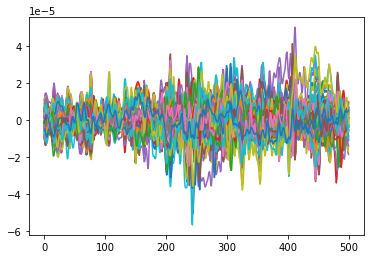

In [4]:
eeg=mne.io.read_epochs_eeglab(data_path+'/S1/eeg/alldata_sbj01_sess1_MATBdiff.set', verbose=False)
# eeg = io.loadmat(data_path+'/S1/eeg/alldata_sbj01_sess1_MATBdiff.set',appendmat=False)
tmp = eeg.get_data()
# print(tmp.shape)
testVect=np.zeros((1,149*500))
print(tmp[1,0].shape)
print()

    
for i in range (61):
    plt.plot(tmp[0,i])

(61, 500)


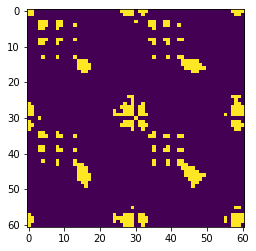

In [5]:
eeg=mne.io.read_epochs_eeglab(data_path+'/S1/eeg/alldata_sbj01_sess1_MATBdiff.set', verbose=False)
# eeg = io.loadmat(data_path+'/S1/eeg/alldata_sbj01_sess1_MATBdiff.set',appendmat=False)
tmp = eeg.get_data()

# for i in range (61):
#     plt.plot(tmp[0,i])

def reshape(signal):
    (a,b,c)=signal.shape
    output=np.zeros((b,a*c))
    for i in range (a):
        for j in range (b):
            output[j,i*500:(i+1)*500]=signal[i,j,:]
    return (output)

            

tmp2 = tmp.view()
tmp2=np.reshape(tmp2,(61,149*500),order='C')


signalTotal=reshape(tmp)

def correlation_threshold(signal,fenetre, indice,k=10**(-10)):
    corr= np.corrcoef(signal[:,indice:indice+fenetre])
    (a,b)=corr.shape
    threshold=np.zeros((a,b))

    for i in range (a):
        for j in range (b):
            if corr[i,j]>k:
                threshold[i,j]=1
    return threshold

def covariance_threshold(signal,fenetre, indice,k=10**(-10)):
    cov= np.cov(signal[:,indice:indice+fenetre])
    print(signal[:,indice:indice+fenetre].shape)
    (a,b)=cov.shape
    threshold=np.zeros((a,b))

    for i in range (a):
        for j in range (b):
            if cov[i,j]>k:
                threshold[i,j]=1
    return threshold

plt.imshow(covariance_threshold(signalTotal,500,1000))


##pour une epoch de 2 secondes
cov=np.cov(tmp[2,:])




##pour les 5 mins

cov2=np.cov(tmp2)
corr2= np.corrcoef(tmp2)



k=10**(-10)
(a,b)=cov.shape
threshold=np.zeros((a,b))

for i in range (a):
    for j in range (b):
        if cov[i,j]>k:
            threshold[i,j]=1
        


1e-09

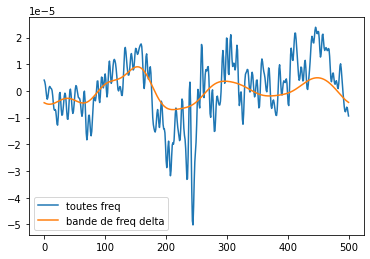

In [6]:
##filtrage fréquentiel

signalTest=tmp[0,0]

def signal_freq_filtre(signal,freqs,fenetre):
    tf=np.fft.fft(signal)

    n = signal.size
    timestep = 1/250
    freq = np.fft.fftfreq(n, d=timestep)

    if freqs=='delta':
        waves=[0.5, 4.5]
    elif freqs=='beta':
        waves=[12 ,35.5]
    elif freqs=='theta':
        waves=[4, 8.5]
    elif freqs=='alpha':
        waves=[8, 12.5]
    elif freqs=='gamma':
        waves=[35, 1000]
    output=np.zeros(len(tf))
    for i in range (len(tf)):
        if i/2 > waves[1] or i/2<=waves[0]:
            tf[i]=0
    output=tf
    return(np.real(np.fft.ifft(output)))
    
plt.plot(signalTest, label="toutes freq")
# plt.plot(signal_freq_filtre(signalTest,'gamma',1)+signal_freq_filtre(signalTest,'beta',1)+signal_freq_filtre(signalTest,'alpha',1)+signal_freq_filtre(signalTest,'delta',1)+signal_freq_filtre(signalTest,'theta',1))
plt.plot(signal_freq_filtre(signalTest,'delta',1),label="bande de freq delta")
plt.legend()

In [7]:

## fonction qui renvoi les 61 signaux de indice à indice+fenetre

def signalCourt(signal,ind, size):
    return signal[:,ind:ind+size]



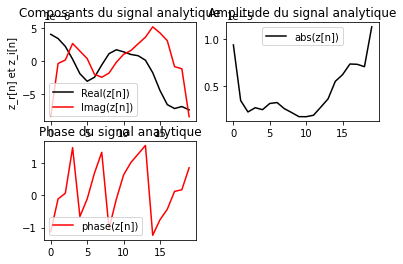

In [8]:
def analytic_signal(x):
    from scipy.fftpack import fft,ifft
    N = len(x)
    X = fft(x,N)
    h = np.zeros(N)
    h[0] = 1
    h[1:N//2] = 2*np.ones(N//2-1)
    h[N//2] = 1
    Z = X*h
    z = ifft(Z,N)
    return z

def phase_analytique(x): #signal analytique en input, renvoi la phase du signal
    phi=np.arctan(x.imag/x.real)
    return phi

def amplitude_analytique(x): #signal analytique en input, renvoi l'enveloppe du signal
    return abs(x)

z = analytic_signal(signalCourt(signalTotal,0,20)[0])
# t = np.arange(start=0,stop=0.5,step=0.001)
    

plt.subplot(2,2,1)
plt.plot(z.real,'k',label='Real(z[n])') #sans axe des temps
plt.plot(z.imag,'r',label='Imag(z[n])') #sans axe des temps
plt.title('Composants du signal analytique')
plt.xlabel('n')
plt.ylabel('z_r[n] et z_i[n]')
plt.legend()

plt.subplot(2,2,2)
plt.plot(amplitude_analytique(z),'k',label='abs(z[n])') #sans axe des temps
# plt.plot(phase,'r',label='phase(z[n])') #sans axe des temps
plt.title('Amplitude du signal analytique')
plt.legend()

plt.subplot(2,2,3)
plt.plot(phase_analytique(z),'r',label='phase(z[n])') #sans axe des temps
plt.title('Phase du signal analytique')
plt.legend()



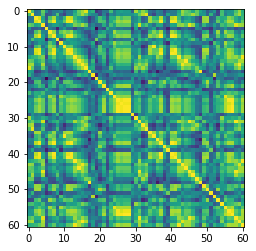

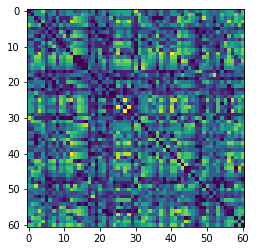

In [9]:
##phase locking value pour un pour une bande de fréquence quelconque

A=np.zeros((61,61))
for i in range (61):
    for j in range (61):
        ph1=phase_analytique(analytic_signal(signal_freq_filtre(signalCourt(signalTotal,0,20)[i],'delta',20)))
        ph2=phase_analytique(analytic_signal(signal_freq_filtre(signalCourt(signalTotal,0,20)[j],'delta',20)))
        dph=ph1-ph2

        PLV=abs(np.sum(np.exp(1j*(dph))))/len(ph1)
        A[i,j]=PLV

plt.figure(1)
plt.imshow(A)
# plt.plot(dph)


##Phase lag index

B=np.zeros((61,61))
for i in range (61):
    for j in range (61):
        ph1=phase_analytique(analytic_signal(signal_freq_filtre(signalCourt(signalTotal,0,20)[i],'delta',20)))
        ph2=phase_analytique(analytic_signal(signal_freq_filtre(signalCourt(signalTotal,0,20)[j],'delta',20)))
        
        dph=ph1-ph2

        PLI=abs(np.sum(np.sign(np.imag(np.exp(1j*(dph))))))/len(ph1)
        B[i,j]=PLI

        
plt.figure(2)
plt.imshow(B)


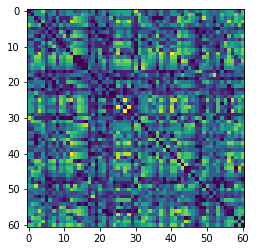

In [10]:
def matPLV(signal, fenetre, indice, freq): #output: la matrice de phase locking values
    A=np.zeros((61,61))
    for i in range (61):
        for j in range (61):
            ph1=phase_analytique(analytic_signal(signal_freq_filtre(signalCourt(signalTotal,indice,fenetre)[i],freq,fenetre)))
            ph2=phase_analytique(analytic_signal(signal_freq_filtre(signalCourt(signalTotal,indice,fenetre)[j],freq,fenetre)))
            dph=ph1-ph2

            PLV=abs(np.sum(np.exp(1j*(dph))))/len(ph1)
            A[i,j]=PLV
    return (A)

def matPLI(signal, fenetre, indice, freq): #output: la matrice de phase lag index
    B=np.zeros((61,61))
    for i in range (61):
        for j in range (61):
            ph1=phase_analytique(analytic_signal(signal_freq_filtre(signalCourt(signal,indice,fenetre)[i],freq,fenetre)))
            ph2=phase_analytique(analytic_signal(signal_freq_filtre(signalCourt(signal,indice,fenetre)[j],freq,fenetre)))
        
            dph=ph1-ph2

            PLI=abs(np.sum(np.sign(np.imag(np.exp(1j*(dph))))))/len(ph1)
            B[i,j]=PLI
    return (B)

plt.imshow(matPLI(signalTotal, 20, 0, 'delta'))



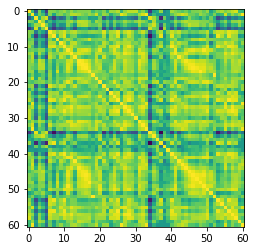

In [11]:
##calcul correlation d'enveloppe


def matCorrEnv(signal, fenetre, indice, freq): #output: matrice de correlation d'enveloppe de signal
    A=np.zeros((61,61))
    corr= np.corrcoef(amplitude_analytique(analytic_signal(signalCourt(signal,indice,fenetre))))
    return (corr)

plt.imshow(matCorrEnv(signalTotal,30,0,'alpha'))

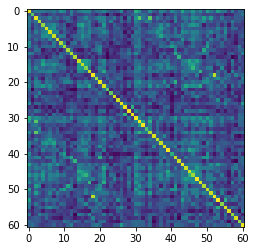

In [12]:
##Comment calculer la IM entre 2 signaux, il faut connaitre leurs distributions probabilistes, on l'estime par les histogrammes ?

def matInfoMut(signal, indice, fenetre,bins):
    A=np.zeros((61,61))
    for i in range (61):
        for j in range (61):
            

            X_norm=signalCourt(signalTotal,indice,fenetre)[i]
            Y_norm=signalCourt(signalTotal,indice,fenetre)[j]
            c_xy = np.histogram2d(X_norm, Y_norm, bins)[0]
            mi= mutual_info_score(None, None, contingency=c_xy)
            A[i,j]=mi
            
    return (A)

plt.imshow(matInfoMut(signalTotal, 1000, 20,5)) ## ne marche pas  ?


In [ ]:
##Information mutuelle

indice=0
fenetre=100

X=signalCourt(signalTotal,indice,fenetre)[0]
Y=signalCourt(signalTotal,indice,fenetre)[1]



[  1.29455958   0.07163361 -32.27972846   2.7367484 ]


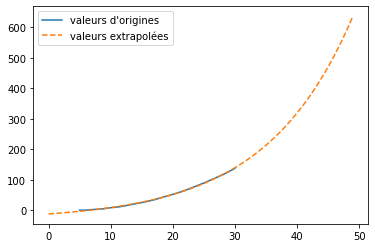

In [13]:
##Ne marche (toujours) pas ?

## PLWT (ie) connectivité basée sur PLV/PLI

alphaTable=np.array([[5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30],
                    [0,0,2,3,5,8,10,13,17,21,25,29,34,40,46,52,58,65,73,81,89,98,107,116,126,137]])

#pour une valeur de confiance à 5%, on retrouves ces valeurs Tcritique en fonction de n (nombre échantillons)

def monoExp(x, m, t, b, c):
    return m * np.exp(t * x+c) + b

p0 = (1, 1, 1, 1) # valeurs initiales pour l'optimisation sequentielle
params, cv = scipy.optimize.curve_fit(monoExp, alphaTable[0][:], alphaTable[1][:], p0)
m, t, b, c = params
print(params)

xs2 = np.arange(50)
ys2 = monoExp(xs2, m, t, b, c)

#Le document "Avoid Thresh with PWLT" conseil que, pour n>30 la distribution des valeurs du signal tend vers une gaussiene
# Je n'arrive pas à trouver le threshold pour cette gaussiene, 
# Je fais donc une approximation exponentielle des valeurs précédentes

def matwPLWT(signal, ind, fenetre, freq): ##output: matrice PLWT de poids

    A=np.zeros((61,61))
    for i in range (61):
        for j in range (61):
            if i !=j:
                theta1=phase_analytique(analytic_signal(signal_freq_filtre(signalCourt(signal,ind,fenetre)[i],freq,fenetre)))
                theta2=phase_analytique(analytic_signal(signal_freq_filtre(signalCourt(signal,ind,fenetre)[j],freq,fenetre)))
                dtheta=theta1-theta2
                sintheta=np.sin(dtheta)
                abssintheta=(abs(np.sin(dtheta)))
                sort=np.sort(abssintheta)
                tpos=0
                tneg=0
                for k in range (len(theta1)):
                    if sintheta[k]>0:
                        K=np.where(abssintheta == abs(sintheta[k]))[0]
                        tpos=tpos+K
                    elif sintheta[k]<0:
                        K=np.where(abssintheta == abs(sintheta[k]))[0]
                        tneg=tneg+K
                PLWT=abs((tpos-tneg)/(tpos+tneg))
                A[i,j]=PLWT
    return (A)

def matPLWT(signal, ind, fenetre, freq,alpha=.05): #output:matrice PLWT binaire (utilisant l'approximation exponentielle pour n>30)

    A=np.zeros((61,61))
    for i in range (61):
        for j in range (61):
            if i !=j:
                theta1=phase_analytique(analytic_signal(signal_freq_filtre(signalCourt(signal,ind,fenetre)[i],freq,fenetre)))
                theta2=phase_analytique(analytic_signal(signal_freq_filtre(signalCourt(signal,ind,fenetre)[j],freq,fenetre)))
                dtheta=theta1-theta2
                sintheta=np.sin(dtheta)
                abssintheta=(abs(np.sin(dtheta)))
                sort=np.sort(abssintheta)
                tpos=0
                tneg=0
                for k in range (len(theta1)):
                    if sintheta[k]>0:
                        K=np.where(abssintheta == abs(sintheta[k]))[0]
                        tpos=tpos+K
                    elif sintheta[k]<0:
                        K=np.where(abssintheta == abs(sintheta[k]))[0]
                        tneg=tneg+K
                T=min(tpos, tneg)
                n=len(theta1)
                if (n<=30) :
                    Tc=alphaTable[1][n-5]
                    if T<Tc:
                        PLWT=1
                    else:
                        PLWT=0
                else:
#                     sig=(n*(n+1)*(2*n+1)/24)
#                     mu=n*(n+1)/4
#                     Z=(T-mu)/(sig)
#                     Zc=1.645 # basé sur gaussienne centrée réduite (ne marche pas)

                    #par extrapolation des valeurs "Tc"
                    Tc=monoExp(n, m, t, b, c)
                    if T<Tc:
                        PLWT=1
                    else:
                        PLWT=0
                A[i,j]=PLWT
    return (A)
## multiplier element par element les 2 matrices pour avoir les poids "connexion"



# plt.imshow(matPLWT(signalTotal, 1000, 20, 'delta'))

plt.plot(alphaTable[0][:],alphaTable[1][:],label="valeurs d'origines")
plt.plot(xs2, ys2, '--',label='valeurs extrapolées')
plt.legend()


(61, 74500)


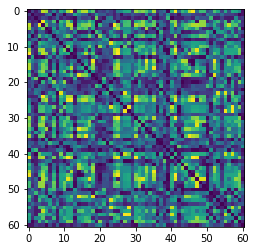

In [24]:
print(signalTotal.shape)
plt.imshow(matwPLWT(signalTotal, 0, 30, 'alpha'))

(61, 61)


(-0.5, 60.5, 60.5, -0.5)

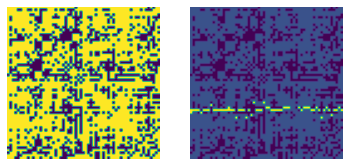

In [16]:
##Pour le minimum spanning tree: donner des matrices binaires en input ? On veut garder les poids les plus significatifs
##On veut en retour un matrices avec les poids les plus significatifs

def MSTMat(mat): #donner en input une matrice avec la diago nulle (?), output: matrice de connectivité minimum spanning tree
    MST=minimum_spanning_tree(-1*mat) #on veut le MST avec les poids maximaux en non minimaux (donc *-1)
    print(MST.shape)
    return (-1*MST.toarray().astype(float))
#     return (MST)

##verifier "toarray"
## essayer une autre fonction decroissante pour MST


##Attention, ne marche pas avec des matrices binaires (?)--> divergence de determinant ?

def emptyDiago(A): #output la matrice mais avec une diagonale vide
    for i in range (A.shape[0]):
        A[i,i]=0
    return (A)

def degreeMat(A): #output: matrice de degrée (termes des lignes sommées sur la diagonale)
    a,b=A.shape
    B=np.zeros((a,b))
    for i in range (a):
        s=0
        for j in range (b):
            s=s+A[i,j]
        B[i,i]=s
    return (B)

def laplacien(A): #renvoi la matrice ayant subit le laplacien
    return (degreeMat(emptyDiago(A))-emptyDiago(A))

# testMat=matPLWT(signalTotal, 1000, 30, 'delta')
testMat=threshold(matInfoMut(signalTotal, 1000, 20,5),0.5)

plt.subplot(1,2,1)
plt.imshow(testMat)
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(3*MSTMat(testMat)+testMat) # on plot le minimum spanning tree au dessus de la matrice de base
plt.axis('off')
#on compare bien, on retrouve bien les poids les plus importants



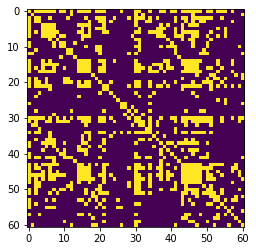

In [15]:
def threshold(mat,k):
    return np.where(mat>k, 1,0)

plt.imshow(threshold(matInfoMut(signalTotal, 1000, 20,5),0.7))

In [17]:
def vectorise(mat):
    return mat[np.triu_indices(mat.shape[0],k=1)]

print(vectorise(testMat).shape)

(1830,)


In [20]:
#Pour 1 session
eeg=mne.io.read_epochs_eeglab(data_path+'/S1/eeg/alldata_sbj01_sess1_MATBdiff.set', verbose=False)
tmp = eeg.get_data()
signalTotal=reshape(tmp)

n=10 #nombre de elements par session
y=np.zeros((n,1))
x=np.zeros((n,1830))
taillef=50 #taille fenetre


N=signalTotal.shape[1] #nombre de samples pour les 5 mins

frequence='alpha'



for i in range (n):
    indice=int((N-taillef)*i/n)
    #signal=signalCourt(signalTotal,indice, taillef)
    x[i,:]=vectorise(matwPLWT(signalTotal, indice, taillef, frequence)).T
    y[i]=2

In [51]:
# Cette fonction créer un vecteur de taille ((n*N)*K) où n*N est le nombre d'instances où l'on calcule une statistique
# à travers les 6 sessions du sujet 1 (n:instants/session et N: nombre de sessions)
# K est la taille du vecteur qui provient de la matrice 61x61 --> K=(60*61)/2
# Output: Y qui est le vecteur qui contient 0,1 ou 2 en fonction de la difficulté de charge mentale

def makeTrain(N,n,taillef,frequence,mesure,bins=5 ): #n est le nombre d'instants par session, N est le nombre de sessions
    data_path='/Users/charlesgirard/Desktop/Centrale/ei2/Projet'
    numberVect=np.array(['1','1','1','2','2','2'])
    M=numberVect.shape[0]
    diffVect=np.array(['diff', 'easy', 'med', 'diff','easy', 'med'])
    y=np.zeros((N*n,1))
    x=np.zeros((N*n,1830))
    
    for k in range (M):
        array='/patient1/alldata_sbj01_sess'+numberVect[k]+'_MATB'+diffVect[k]+'.set'#pointe vers un dossier avec toutes les sessions d'un meme sujet réuni
        eeg=mne.io.read_epochs_eeglab(data_path+array, verbose=False)
        tmp = eeg.get_data()
        signalTotal2=reshape(tmp)
#         print(signalTotal2.shape)
        
        for i in range (n):
            indice=int((signalTotal.shape[1]-taillef)*i/n)
            if mesure== 'wPLWT':
                mat=matwPLWT(signalTotal2, indice, taillef, frequence)
            elif mesure== 'infoMut':
                mat=matInfoMut(signalTotal2, indice, taillef,bins)
            elif mesure== "PLV":
                mat=matPLV(signalTotal2, taillef, indice, frequence)
            x[n*k+i,:]=vectorise(mat).T

            if diffVect[k]== 'easy':
                y[n*k+i]=0
            elif diffVect[k]== 'med':
                y[n*k+i]=1
            elif diffVect[k]== 'diff':
                y[n*k+i]=2
    return (x,y)


In [53]:
(X1,Y1)=makeTrain(6,3,30,'alpha','wPLWT',5)
plt.figure(figsize=(100,10))
plt.imshow(X1,aspect=10)


Error in callback <function flush_figures at 0x11acfce50> (for post_execute):


KeyboardInterrupt: 

3.8.3 (default, Jul  2 2020, 11:26:31) 
[Clang 10.0.0 ]


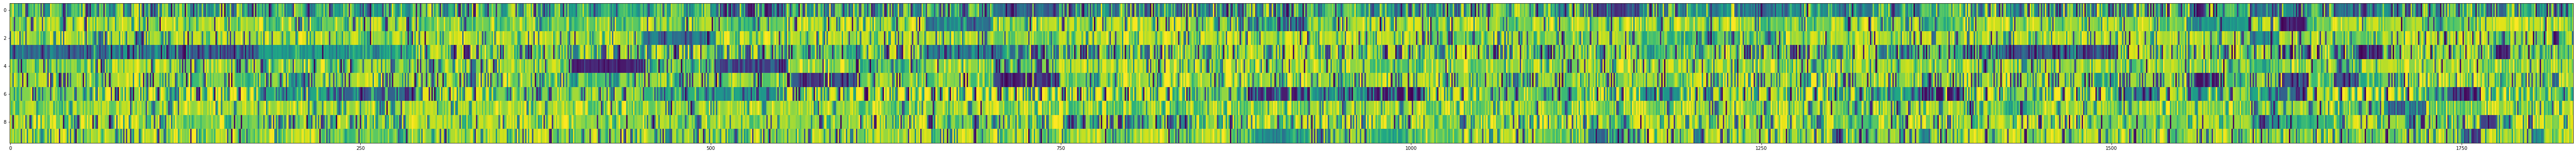

In [21]:
plt.figure(figsize=(100,10))
plt.imshow(x,aspect=10)
# '/patient1/alldata_sbj01_sess'+'0000'+'_MATB'+'aaaaaa'+'.set'
import sys;print(sys.version)

In [40]:
# de meme que makeTrain, mais renvoi un vecteur de matrices SPD au lieu que d'un vecteur
def makeTrainMat(N,n,taillef,frequence,mesure,bins=5 ): #n est le nombre d'instants par session, N est le nombre de sessions
    data_path='/Users/charlesgirard/Desktop/Centrale/ei2/Projet'
    numberVect=np.array(['1','1','1','2','2','2'])
    M=numberVect.shape[0]
    diffVect=np.array(['diff', 'easy', 'med', 'diff','easy', 'med'])
    y=np.zeros((N*n,1))
    x=np.zeros((N*n,61,61))
    
    for k in range (M):
        array='/patient1/alldata_sbj01_sess'+numberVect[k]+'_MATB'+diffVect[k]+'.set'#pointe vers un dossier avec toutes les sessions d'un meme sujet réuni
        eeg=mne.io.read_epochs_eeglab(data_path+array, verbose=False)
        tmp = eeg.get_data()
        signalTotal2=reshape(tmp)    
        for i in range (n):
            indice=int((signalTotal.shape[1]-taillef)*i/n)
            if mesure== 'wPLWT':
                mat=matwPLWT(signalTotal2, indice, taillef, frequence)
            elif mesure== 'infoMut':
                mat=matInfoMut(signalTotal2, indice, taillef,bins)
            elif mesure== "PLV":
                mat=matPLV(signalTotal2, taillef, indice, frequence)
            x[n*k+i,:,:]=mat

            if diffVect[k]== 'easy':
                y[n*k+i]=0
            elif diffVect[k]== 'med':
                y[n*k+i]=1
            elif diffVect[k]== 'diff':
                y[n*k+i]=2
    return (x,y)


In [41]:
(X1,Y1)=makeTrainMat(10,3,30,'alpha','wPLWT',5)


In [47]:
Xtrain=X1[0:7]
Xtest=X1[7:10]
Ytrain=Y1[0:7]
Ytest=Y1[7:10]

In [49]:
clf=KNearestNeighbor()
clf.fit(Xtrain,Ytrain)
clf.get_params()
clf.predict(Xtest)

LinAlgError: The leading minor of order 1 of B is not positive definite. The factorization of B could not be completed and no eigenvalues or eigenvectors were computed.